# Structured Pruning Adapter demo
This notebook presents a small demo of how to use the modules within this library. 
Specifically, we'll show how to replace regular `torch.nn.Linear` modules with either the `SPLoRALinear` or `SPLoPALinear` modules.

## Data preparation
We'll use good 'ol MNIST (Lecun et al., "MNIST handwritten digit database", 2010) for demonstration purposes. 
The code below downloads and defines our dataset loaders.

In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)

train_loader = DataLoader(
    train_data,
    batch_size = 64,
    shuffle=True,
)

test_loader = DataLoader(
    test_data,
    batch_size = 64,
)

In [13]:
data, targets = next(iter(train_loader))
data.shape, targets.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

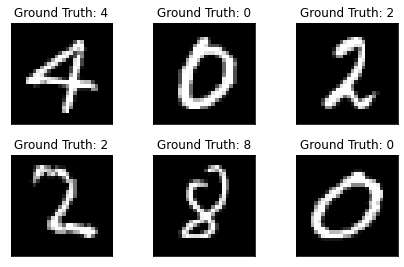

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(targets[i]))
    plt.xticks([])
    plt.yticks([])

## Network and train/eval loop definition

In [15]:
from torch.nn import Linear, Module
from torch.nn.functional import relu, log_softmax, nll_loss
from torch.optim import SGD


class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = Linear(28*28, 512)
        self.fc2 = Linear(512, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = relu(self.fc1(x))
        x = self.fc2(x)
        output = log_softmax(x, dim=1)
        return output

    
def train(
    model:Module, 
    train_loader:DataLoader, 
    optimizer: SGD, 
    epoch:int, 
    log_interval = 50
):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Reset the gradients
        optimizer.zero_grad() 
        
        # Feed the data through the model
        output = model(data) 
        
        # Compute the negative log-likelihood loss
        loss = nll_loss(output, target) 
        
        # Backward propagate the gradients
        loss.backward() 
        
        # Perform an update step using the optimizer
        optimizer.step() 
        
        # Log
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model:Module, test_loader:DataLoader):
    # Set model to evaluation mode
    model.eval()
    
    test_loss = 0
    correct = 0
    
    # Don't accumulate gradients
    with torch.no_grad():
        for data, target in test_loader:
            # Feed the data through the model
            output = model(data)
            
            # Sum up batch loss
            test_loss += nll_loss(output, target, reduction='sum').item()  
            
            # The prediction is the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)  
            
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
    ))

model = Net()
model

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [16]:
# Train the network
optimizer = SGD(model.parameters(), lr=0.01)

epochs = 1
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch, log_interval=50)
    test(model, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286661
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.370934
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.876042
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.858590
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.598378
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.685343
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.476306
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.406651
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.332864
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.488603
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.363647
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.366195
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.406011
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.237738
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.379779
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.338978
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.630778
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.339750
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.421570

Test set: Average loss: 0.3043, Accuracy: 9139/10000 (91%)

## SPLoPA: Structured Pruning Low-rank PHM Adapter
We can convert the whole network according to a single SPLoPA specification as follows:

In [17]:
from sp_adapters import SPLoPA

model_splopa = SPLoPA(model, num_prototypes=64, block_shape=(16,16), prototype_rank=2)

# Weights are copied
assert torch.equal(model_splopa.fc1.weight, model.fc1.weight)
assert torch.equal(model_splopa.fc2.weight, model.fc2.weight)

model_splopa

Unable to convert 'fc2' (Linear(in_features=512, out_features=10, bias=True)): Weight shape should be devisible by block shape, but found (10, 512) and (16, 16)


Net(
  (fc1): SPLoPALinear(
    in_features=784, out_features=512, bias=True
    (adapter): SPLoPAdapter(
      (prototypes): LowRankMatrix(64, 16, 16)
    )
  )
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

This will skip any modules that aren't convertible. For instance, `fc2` can't be converted with a `block_shape=(16,16)` since it `out_features=10`.

If we need more fine-grained control, we can specify each layer the usual way:

In [18]:
from sp_adapters import SPLoPALinear


class NetSPLoPA(Module):
    def __init__(self, num_prototypes=64):
        super(NetSPLoPA, self).__init__()
        self.fc1 = SPLoPALinear(28*28, 512, num_prototypes=num_prototypes, block_shape=(16,16), prototype_rank=2)
        self.fc2 = SPLoPALinear(512, 10, num_prototypes=num_prototypes, block_shape=(10,16), prototype_rank=2)

    def forward(self, x): # Same as in class `Net`
        x = torch.flatten(x, 1)
        x = relu(self.fc1(x))
        x = self.fc2(x)
        output = log_softmax(x, dim=1)
        return output

model_splopa = NetSPLoPA(num_prototypes=64)

model_splopa.load_state_dict(model.state_dict(), strict=False)

_IncompatibleKeys(missing_keys=['fc1.adapter_bias', 'fc1.adapter.pos_weights', 'fc1.adapter.prototypes.cols', 'fc1.adapter.prototypes.rows', 'fc2.adapter_bias', 'fc2.adapter.pos_weights', 'fc2.adapter.prototypes.cols', 'fc2.adapter.prototypes.rows'], unexpected_keys=[])

In [11]:
# Continue training
optimizer = SGD(model_splopa.parameters(), lr=0.1)

epochs = 1
for epoch in range(1, epochs + 1):
    train(model_splopa, train_loader, optimizer, epoch, log_interval=50)
    test(model_splopa, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.171727
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.115079
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.186595
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.182920
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.353604
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.231037
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.187666
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.304213
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.206940
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.216079
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.136944
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.228789
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.314883
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.301132
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.282785
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.241042
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.234235
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.208394
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.175386

Test set: Average loss: 0.2363, Accuracy: 9322/10000 (93%)

In [20]:
# Weights still match
assert torch.equal(model_splopa.fc1.weight, model.fc1.weight)
assert torch.equal(model_splopa.fc2.weight, model.fc2.weight)

# But adapted weights are different!
assert not torch.equal(model_splopa.fc1.adapted_weight, model.fc1.weight)
assert not torch.equal(model_splopa.fc2.adapted_weight, model.fc2.weight)

## SPLoPA weight visualisation
Let's visualise our updated weights. While the `weight` attribute remains unchanged through training, the `adapted_weights` differs. 

It is made up of weighted prototypes, which have a much smaller memory footprint!

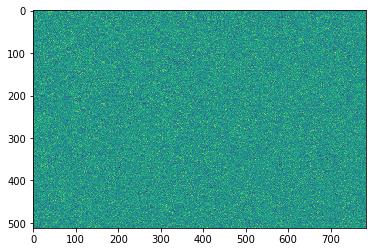

In [25]:
def show(weight):
    plt.imshow(weight.detach().numpy(), interpolation='nearest')
    plt.show()

show(model_splopa.fc1.weight - model_splopa.fc1.adapted_weight)

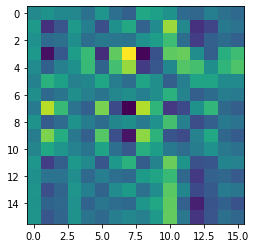

In [26]:
show(model_splopa.fc1.adapter.prototypes()[0])

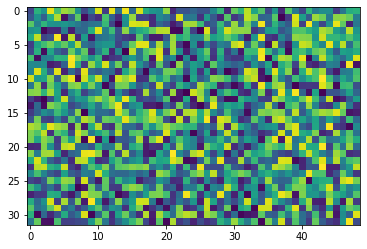

In [29]:
show(model_splopa.fc1.adapter.pos_weights[0])

## SPLoRA: Structured Pruning Low-rank Adapter
Your turn, just replace `SPLoPA` with `SPLoRA` in the above example.

In [ ]:
from sp_adapters import SPLoRA, SPLoRALinear